In [1]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dysts.flows import DoublePendulum
# ------------------------
# Parameters
# ------------------------
# time step duration (in time unit)
dt = 0.25
# training time (in time unit)
train_time  = 80.
# testing time (idem)
test_time   = 10.
# warmup time (idem): should always be > k * s
warm_time   = 50.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

total_time = train_time + test_time + warm_time
print("Total time: ", total_time)

n_timesteps = train_steps + test_steps + warm_steps
print("Total steps: ", n_timesteps)

model = DoublePendulum()

model.ic = np.array([np.pi / 1, 2.0, np.pi / 1, 1.0])

X = model.make_trajectory(n_timesteps, postprocess=False)

print(X.shape)


Total time:  140.0
Total steps:  560
(560, 4)


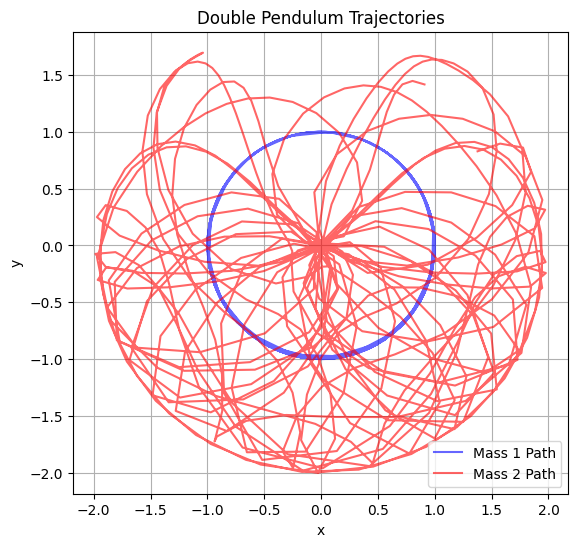

In [3]:

l1 = 1.0  # length of first pendulum
l2 = 1.0  # length of second pendulum

# ------------------------
# Convert to Cartesian: (x1, y1), (x2, y2)
def plot_data(th1, th2):

    # ------------------------
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)

    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)

    cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

    # ------------------------
    # Plot the trajectory
    # ------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
    plt.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
    plt.title("Double Pendulum Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data(X[:,0], X[:,1])


In [4]:
from reservoirpy.nodes import Ridge, NVAR
nvar = NVAR(delay=1, order=2, strides=1) # 6 is good for order
readout = Ridge(4, ridge=1e-4, input_bias=False)

model = nvar >> readout

In [5]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

model = model.fit(Xi, dXi, warmup=warm_steps)

nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Xi shape: (519, 4), dXi shape: (519, 4)


Running Model-0: 519it [00:00, 3861.73it/s]0<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

Fitting node Ridge-0...



Running NVAR-0: 100%|██████████| 2/2 [00:00<00:00, 3477.86it/s]


(40, 4)
(40, 4)


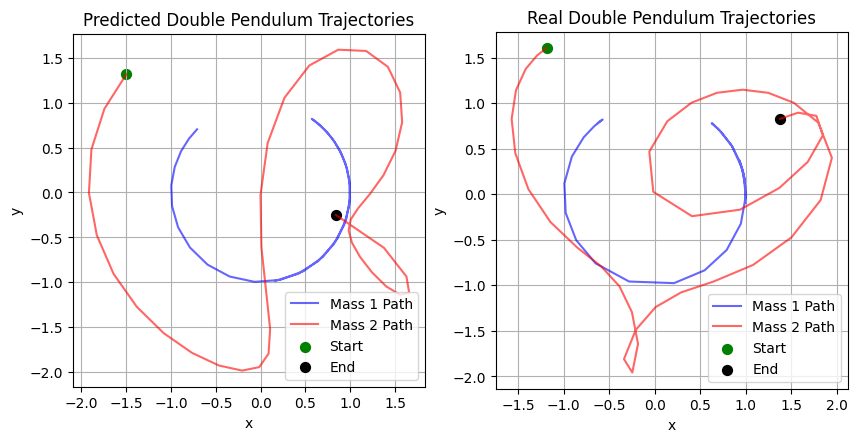

In [6]:
N = test_steps
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(10, 10))

# Predicted Trajectory
ax = fig.add_subplot(121)
ax.set_title("Predicted Double Pendulum Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(False)

th1 = res[:, 0]
th2 = res[:, 1]
x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

ax.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)

# Add starting and ending points
ax.scatter(x2[0], y2[0], color='green', s=50, label='Start')
ax.scatter(x2[-1], y2[-1], color='black', s=50, label='End')

ax.set_aspect('equal')
ax.legend()
ax.grid(True)


# Real Trajectory
ax2 = fig.add_subplot(122)
ax2.set_title("Real Double Pendulum Trajectories")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

th1 = Y[:, 0]
th2 = Y[:, 1]

x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

ax2.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax2.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)

# Add starting and ending points
ax2.scatter(x2[0], y2[0], color='green', s=50, label='Start')
ax2.scatter(x2[-1], y2[-1], color='black', s=50, label='End')

ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True)

print(res.shape)
print(Y.shape)


In [7]:
%matplotlib widget
import matplotlib.pyplot as plt

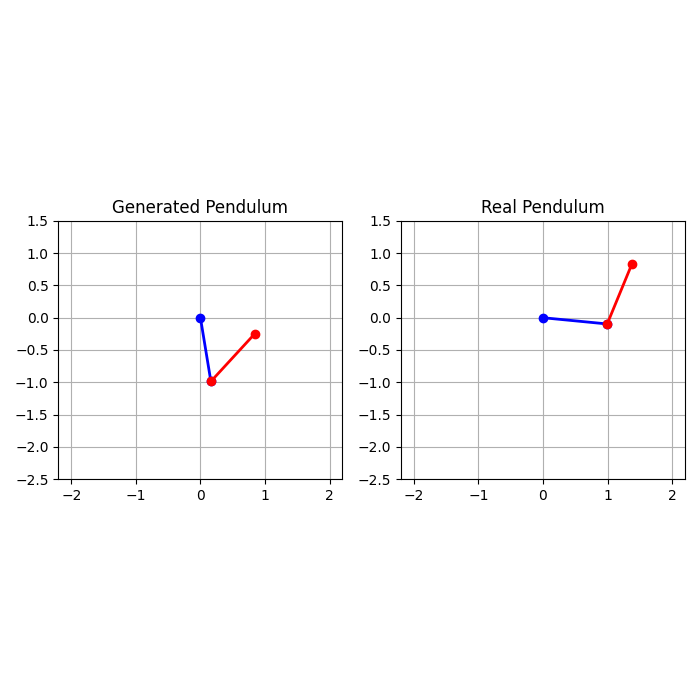

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter

# --- Pendulum lengths ---
l1, l2 = 1.0, 1.0

# --- Trajectory Data (already computed) ---
# X = full trajectory
# res = generated
# Y = ground truth
# test_steps, train_steps, warm_steps already defined

N = test_steps
Y = X[warm_steps + train_steps:]

# --- Helper: Convert angles to positions ---
def get_positions(data):
    th1, th2 = data[:, 0], data[:, 1]
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)
    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)
    return x1, y1, x2, y2

# --- Get both trajectories in Cartesian coordinates ---
x1_res, y1_res, x2_res, y2_res = get_positions(res)
x1_true, y1_true, x2_true, y2_true = get_positions(Y)

# --- Set up figure and axes ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))

for ax in (ax1, ax2):
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)

ax1.set_title("Generated Pendulum")
ax2.set_title("Real Pendulum")

# --- Initialize lines ---
gen_line1, = ax1.plot([], [], 'o-', lw=2, color='blue')
gen_line2, = ax1.plot([], [], 'o-', lw=2, color='red')

true_line1, = ax2.plot([], [], 'o-', lw=2, color='blue')
true_line2, = ax2.plot([], [], 'o-', lw=2, color='red')

# --- Initialization function ---
def init():
    gen_line1.set_data([], [])
    gen_line2.set_data([], [])
    true_line1.set_data([], [])
    true_line2.set_data([], [])
    return gen_line1, gen_line2, true_line1, true_line2

# --- Update function for animation ---
def update(frame):
    # Generated
    gen_line1.set_data([0, x1_res[frame]], [0, y1_res[frame]])
    gen_line2.set_data([x1_res[frame], x2_res[frame]], [y1_res[frame], y2_res[frame]])

    # Real
    true_line1.set_data([0, x1_true[frame]], [0, y1_true[frame]])
    true_line2.set_data([x1_true[frame], x2_true[frame]], [y1_true[frame], y2_true[frame]])

    return gen_line1, gen_line2, true_line1, true_line2

# --- Create animation ---
ani = FuncAnimation(fig, update, frames=N, init_func=init, blit=True, interval=20)

FFwriter = FFMpegWriter(fps=10)
ani.save('./pendulum_4.mp4', writer=FFwriter)

plt.tight_layout()
plt.show()


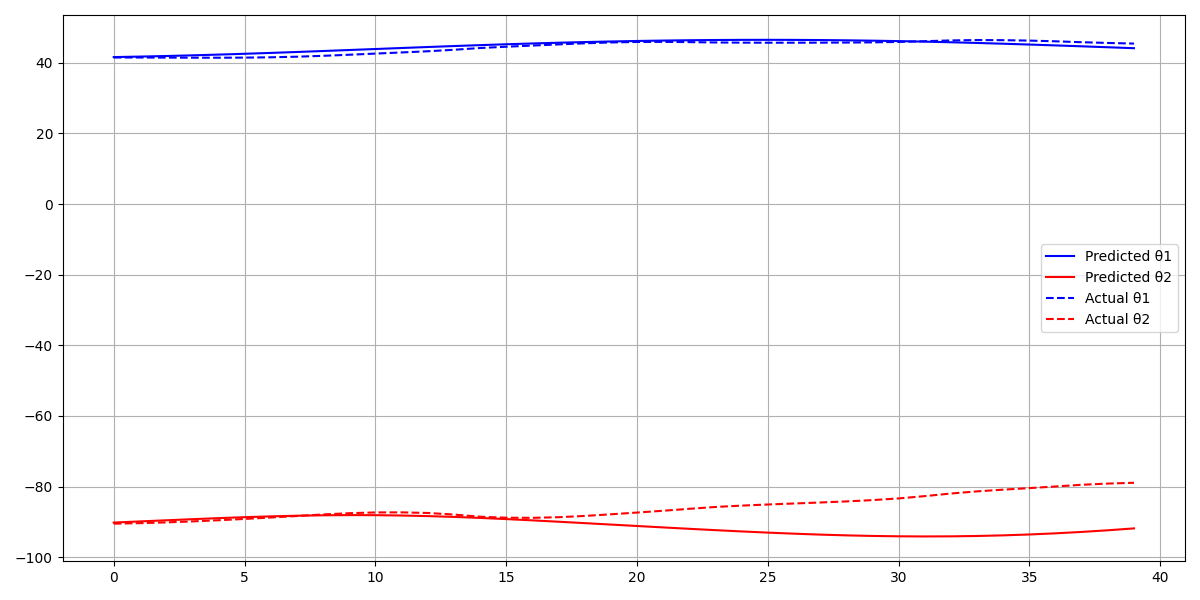

In [9]:
plt.figure(figsize=(12, 6))

N_new = 40
# Plot predicted (generated) angles
plt.subplot(1, 1, 1)
plt.plot(np.arange(N_new), res[:N_new, 0], label='Predicted θ1', color='blue')
plt.plot(np.arange(N_new), res[:N_new, 1], label='Predicted θ2', color='red')
plt.plot(np.arange(N_new), Y[:N_new, 0], label='Actual θ1', color='blue', linestyle='--')
plt.plot(np.arange(N_new), Y[:N_new, 1], label='Actual θ2', color='red', linestyle='--')

plt.legend()
plt.grid(True)

plt.grid(True)

plt.tight_layout()
plt.show()